### Dependencies
____

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_ols, pacf_yw
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

#### Load Data
____

In [20]:
dataset = '../resources/daily_household_power_consumption.csv'

master = pd.read_csv(dataset, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

master.index.freq='D'
master.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='datetime', length=1442, freq='D')

#### Split Train and Test Data
____

In [28]:
prediction_days = 90
cutoff_date = master.index.max() - pd.Timedelta(days=prediction_days)

cond_train = master.index <= cutoff_date  
cond_test  = master.index > cutoff_date    # max forecast time = 1 year

test = master[cond_test]
train = master[cond_train]

print(f'Train : {train.shape} - Test : {test.shape}')
print(f'Train Range : \n\tFrom : {train.index.min()} To : {train.index.max()}')
print(f'Test Range : \n\tFrom : {test.index.min()} To : {test.index.max()}')

Train : (1352, 8) - Test : (90, 8)
Train Range : 
	From : 2006-12-16 00:00:00 To : 2010-08-28 00:00:00
Test Range : 
	From : 2010-08-29 00:00:00 To : 2010-11-26 00:00:00


#### Fit Model
____

In [29]:
model = ExponentialSmoothing(train['Global_active_power'], trend='add', seasonal='mul', seasonal_periods=7).fit()

In [31]:
train['Global_active_power']

datetime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
                ...   
2010-08-24     722.948
2010-08-25     980.408
2010-08-26     757.252
2010-08-27    2030.650
2010-08-28    1442.856
Freq: D, Name: Global_active_power, Length: 1352, dtype: float64

#### Perform Predictions
____

In [23]:
predictions = model.forecast(steps=prediction_days)    # next 30 days


#### Plot Results
____

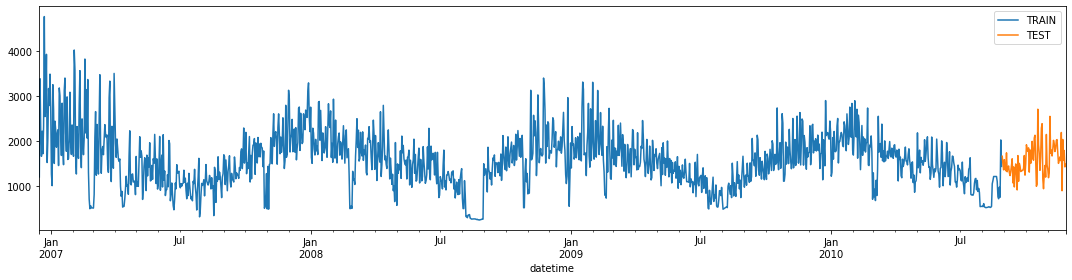

In [24]:
train['Global_active_power'].plot(legend=True, label='TRAIN', figsize=(15,4))
test['Global_active_power'].plot(legend=True, label='TEST', figsize=(15,4))

plt.tight_layout()

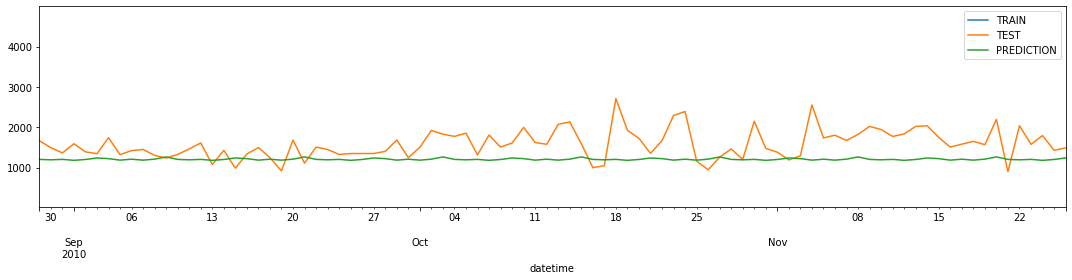

In [25]:
train['Global_active_power'].plot(legend=True, label='TRAIN', figsize=(15,4))
test['Global_active_power'].plot(legend=True, label='TEST', figsize=(15,4))
predictions.plot(legend=True, label='PREDICTION', figsize=(15,4), xlim=['2010-08-29', '2010-11-26'])

plt.tight_layout()

#### Prediction evaluation
____

In [10]:
test.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,kitchen_active_energy,laundry_active_energy,water_heater_ac_active_energy,equipment_active_energy
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,1580.553800,180.408133,347093.905333,6679.840000,1601.044444,1571.077778,9870.855556,13299.585555
std,357.945804,35.827495,5292.080388,1505.922243,1294.591540,1934.993402,2796.931768,3135.620762
min,900.910000,116.128000,303487.570000,3798.600000,0.000000,385.000000,3911.000000,7284.099991
25%,1347.432000,158.170000,346400.880000,5689.500000,960.250000,594.500000,7960.750000,10737.549998
50%,1510.425000,179.054000,347125.460000,6409.100000,1129.500000,740.000000,9775.000000,13420.550017
75%,1791.176000,196.411500,348328.837500,7565.850000,2098.500000,1974.250000,11980.000000,15792.566635
max,2713.884000,327.446000,354786.620000,11380.800000,6029.000000,11193.000000,16593.000000,19322.199958


In [26]:
# compare mean_abs x std_dev
mean_absolute_error(y_true=test['Global_active_power'], y_pred=predictions)

411.69859304745404

In [12]:
# compare the result x std
# higher than std, not good performance yet
np.sqrt(mean_squared_error(y_true=test['Global_active_power'], y_pred=predictions))

393.1073040116168

#### Forecasting into future
____

In [14]:
model = ExponentialSmoothing(master['Global_active_power'], trend='add', seasonal='mul', seasonal_periods=7).fit()

forecast = model.forecast(steps=prediction_days)

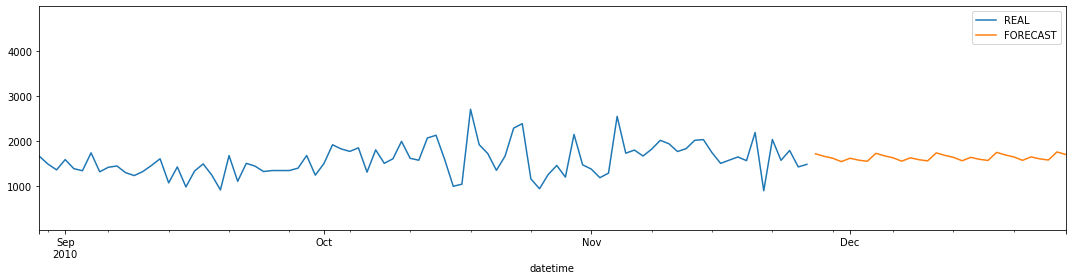

In [15]:
master['Global_active_power'].plot(legend=True, label='REAL', figsize=(15,4))
forecast.plot(legend=True, label='FORECAST', figsize=(15,4), xlim=['2010-08-29', '2010-12-26'])

plt.tight_layout()

#### TimeSeries Correlation Analysis
____

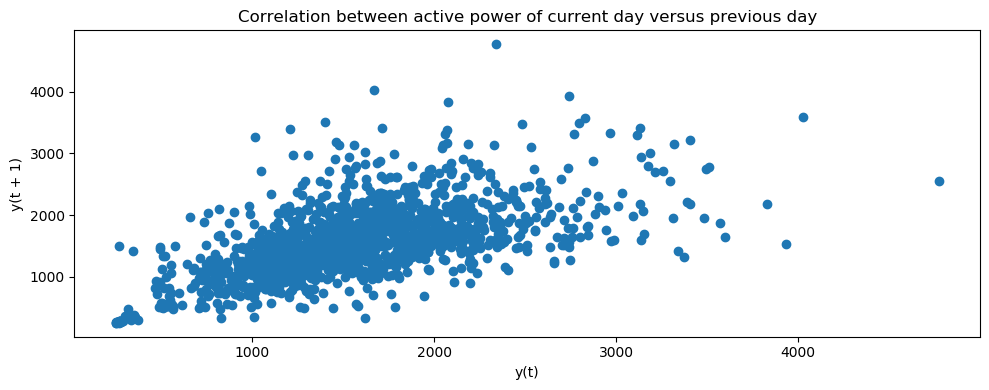

In [16]:
fig, axes =  plt.subplots(nrows=1, ncols=1, figsize=(10,4), dpi=100)

lag_plot(master['Global_active_power'], ax=axes)
axes.set_title('Correlation between active power of current day versus previous day')

plt.tight_layout()

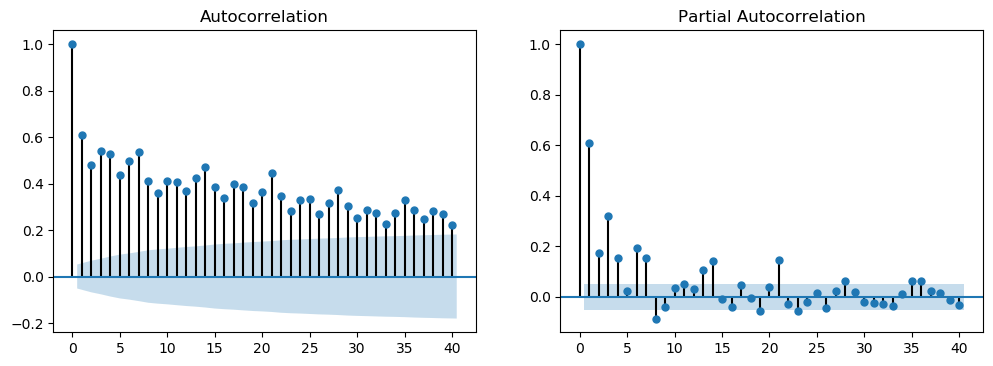

In [17]:
fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=100)

plot_acf(master['Global_active_power'], ax=axes[0], lags=40);
plot_pacf(master['Global_active_power'], ax=axes[1], lags=40);